# System Identification in Frequency Domain

In [131]:
import os
import pywt
import itertools
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from scipy.signal import welch
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy.io import loadmat

# Loading The Dataset (Trial by Trial)

In [132]:
# Get the participant data from Dataset directory
num_eeg_ch = 14
num_emg_ch = 4
num_force_ch = 3
num_conds = 18
file = loadmat('YZ1200Hz.mat')
data = pd.DataFrame(columns=['EEG-1','EEG-2','EEG-3','EEG-4','EEG-5',
                             'EEG-6','EEG-7','EEG-8','EEG-9','EEG-10',
                             'EEG-11','EEG-12','EEG-13','EEG-14','EMG-1',
                             'EMG-2','EMG-3','EMG-4','Force-x', 
                             'Force-y','Force-z'])
temp1 = data.copy()
# for cond in range(num_conds):
cond = 0
for ch in range(num_eeg_ch):
    temp1.iloc[:,ch] = file['EEGSeg_Ch'][0,ch][0,cond].flatten()
for ch in range(num_emg_ch):
    temp1.iloc[:,ch+num_eeg_ch] = file['EMGSeg_Ch'][0,ch][0,cond].flatten()
for ch in range(num_force_ch):
    temp1.iloc[:,ch+num_eeg_ch+num_emg_ch] = file['ForceSeg_Ch'][0,ch][0,cond].flatten()
data = data.append(temp1, ignore_index=True)
del temp1

num_trials = file['EEGSeg_Ch'][0,0][0,cond].shape[0]
num_samples_per_trial = file['EEGSeg_Ch'][0,0][0,cond].shape[1]

data_splitBy_trials = np.array_split(data, num_trials)
# mean subtraction in each trial from the eeg columns
# for subtracting dc shift
for trial in range(num_trials):
    data_splitBy_trials[trial].iloc[:,:] -= data_splitBy_trials[trial].iloc[:,:].mean()
    # convert volts to microvolts for EEG and EMG channels
    data_splitBy_trials[trial].values[:,:18] *= 1e6
    # convert volts to milivolts for force channels
    data_splitBy_trials[trial].values[:,18:] *= 1e3    

In [133]:
t0=0
fs=1200
dt=1.0/fs
time = (np.arange(0, num_samples_per_trial) * dt + t0) * 1e3
# pick one channel from eeg, emg and force
eeg_signal_1 = data_splitBy_trials[0].iloc[:,0] # trial 1, eeg_ch1
emg_signal_1 = data_splitBy_trials[0].iloc[:,14] # trial 1, emg_ch1
force_signal_3 = data_splitBy_trials[0].iloc[:,20] # trial 1, force_ch3

# Visualization of The Dataset

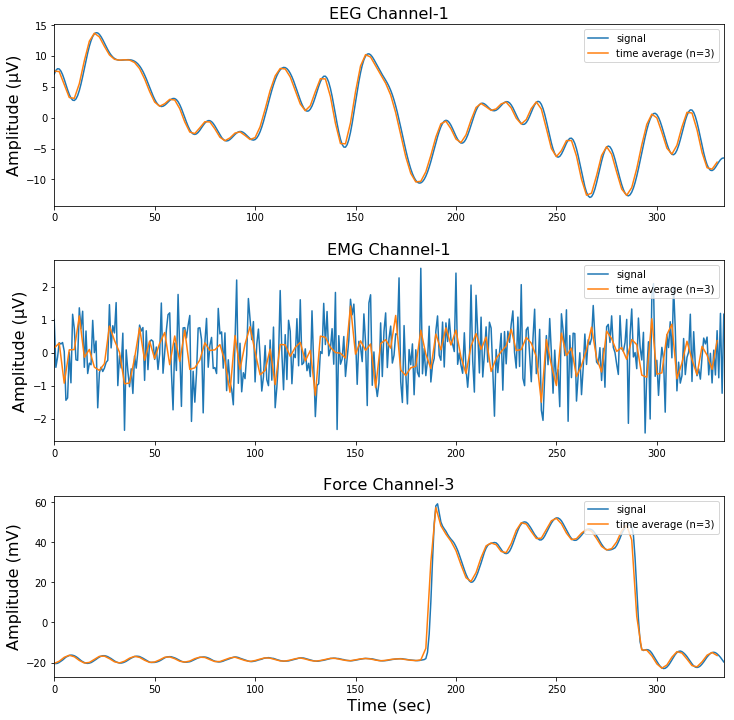

In [134]:
def get_ave_values(xvalues, yvalues, n):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(average_over))
    ax.set_xlim([time[0], time[-1]])
    ax.legend(loc='upper right')

fig, axes = plt.subplots(3, figsize=(12,12))
fig.subplots_adjust(hspace=0.3)
plot_signal_plus_average(axes[0], time, eeg_signal_1, average_over=3)

axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[0].set_title('EEG Channel-1', fontsize=16)
plot_signal_plus_average(axes[1], time, emg_signal_1, average_over=3)

axes[1].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_title('EMG Channel-1', fontsize=16)
plot_signal_plus_average(axes[2], time, force_signal_3, average_over=3)

axes[2].set_ylabel('Amplitude (mV)', fontsize=16)
axes[2].set_xlabel('Time (sec)', fontsize=16)
axes[2].set_title('Force Channel-3', fontsize=16)

plt.show()

# Fourier Transform of The Data

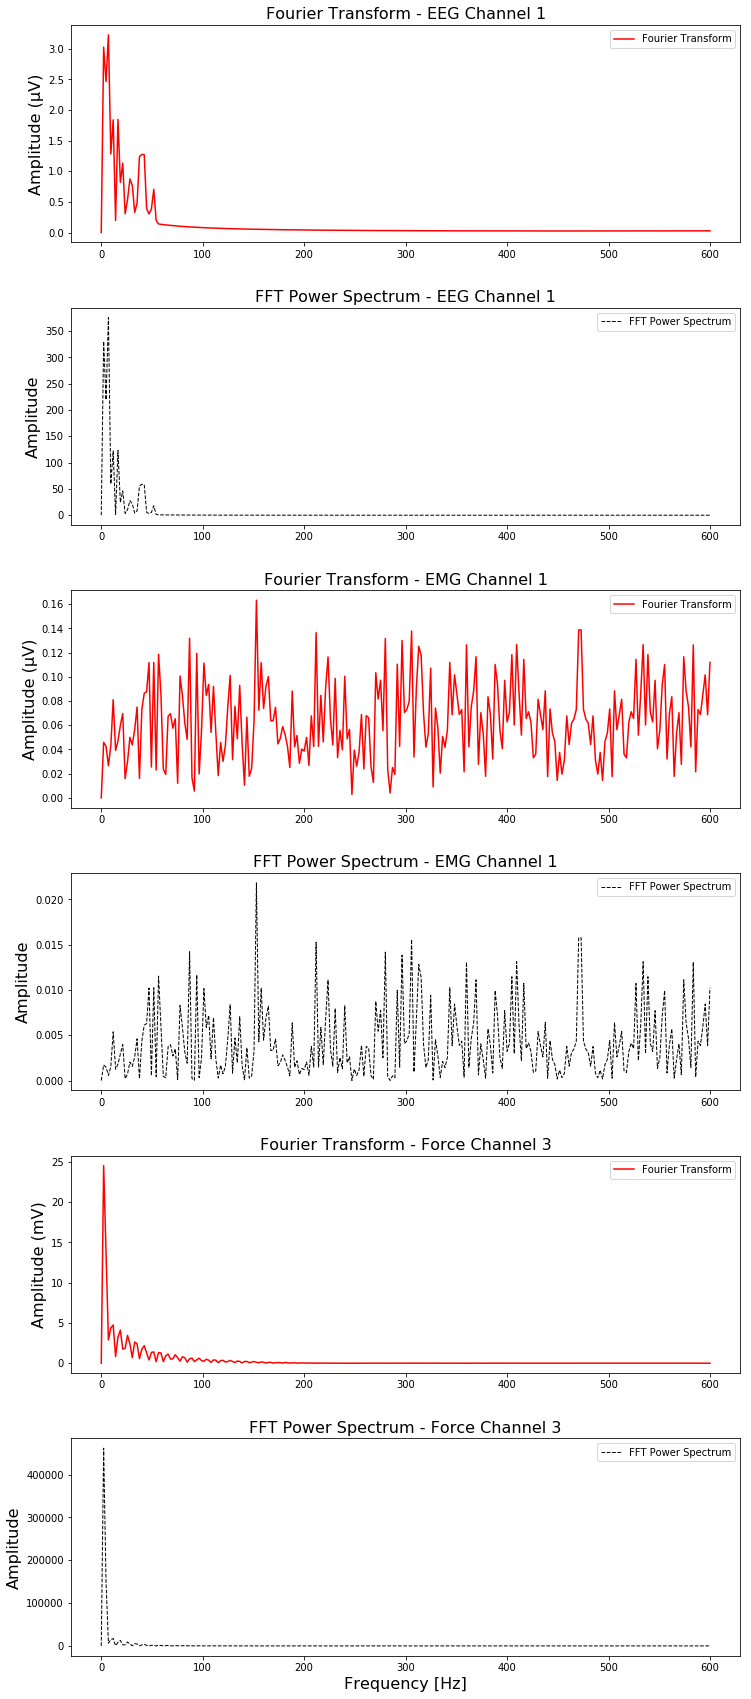

In [135]:
def get_fft_values(y_values, T, N, f_s):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    f_values = np.linspace(0.0, 1.0/(2.0*T), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

def plot_fft_plus_power(axes, time, signal, fs=fs, dt=dt, N=num_samples_per_trial,
                        plot_direction='horizontal', yticks=None, ylim=None):
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2

    if plot_direction == 'horizontal':
        axes[0].plot(f_values, fft_values, 'r-', label='Fourier Transform')
        axes[1].plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        axes[0].plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        axes[1].plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        axes[0].set_yticks(np.log2(yticks))
        axes[0].set_yticklabels(yticks)
        axes[0].invert_yaxis()
        axes[0].set_ylim(ylim[0], -1)
    axes[0].legend()
    axes[1].legend()

fig, axes = plt.subplots(6, figsize=(12,30))
fig.subplots_adjust(hspace=0.3)
axes[0].set_title('Fourier Transform - EEG Channel 1', fontsize=16)
axes[1].set_title('FFT Power Spectrum - EEG Channel 1', fontsize=16)
axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[0], axes[1]], time, eeg_signal_1)

axes[2].set_title('Fourier Transform - EMG Channel 1', fontsize=16)
axes[3].set_title('FFT Power Spectrum - EMG Channel 1', fontsize=16)
axes[2].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[3].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[2], axes[3]], time, emg_signal_1)

axes[4].set_title('Fourier Transform - Force Channel 3', fontsize=16)
axes[5].set_title('FFT Power Spectrum - Force Channel 3', fontsize=16)
axes[4].set_ylabel('Amplitude (mV)', fontsize=16)
axes[5].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[4], axes[5]], time, force_signal_3)
axes[5].set_xlabel('Frequency [Hz]', fontsize=16)

plt.show()

# Estimation of The Power Spectral Density Using Welch’s Method

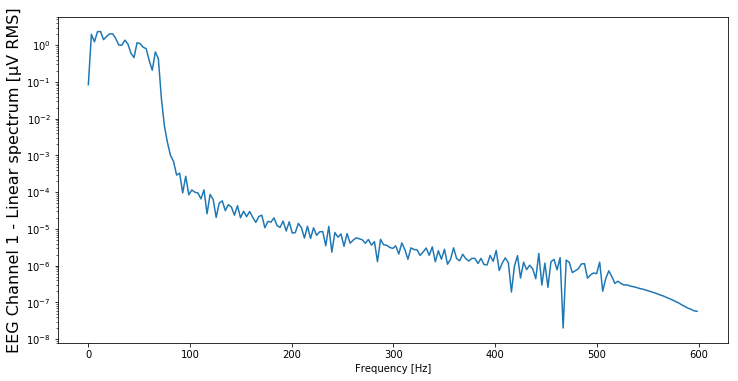

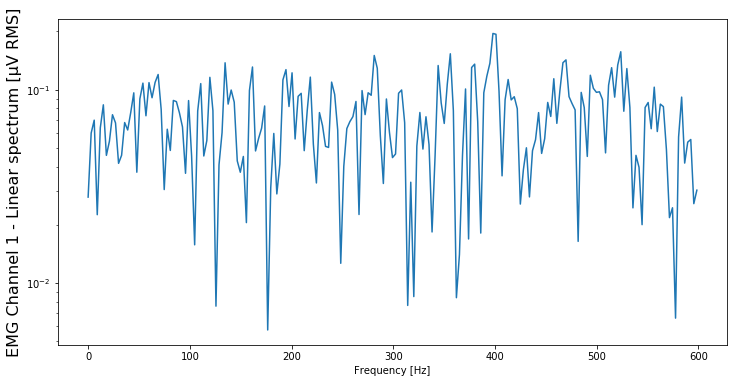

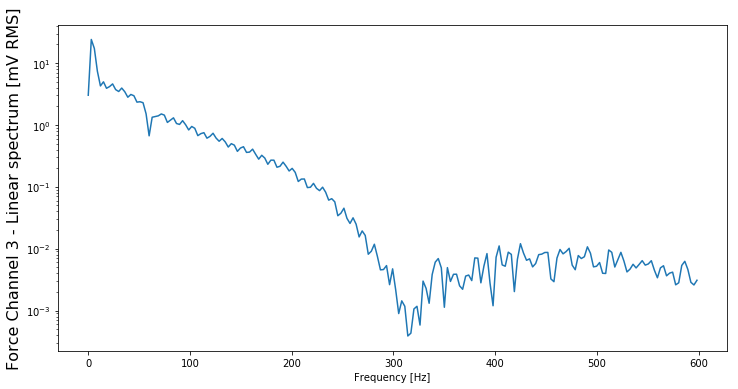

In [136]:
# Welch’s method computes an estimate of the power spectral density by dividing the data
# into overlapping segments, computing a modified periodogram for each segment 
# and averaging the periodograms.

# For the default ‘hanning’ window an overlap of 50% is a reasonable trade off 
# between accurately estimating the signal power, while not over counting any of the data. 
# Narrower windows may require a larger overlap.
for counter, x in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    f, Pxx_spec = welch(x, fs, 'hanning', num_samples_per_trial, scaling='spectrum')
    plt.figure(figsize=(12,6))    
    plt.semilogy(f, np.sqrt(Pxx_spec))
    plt.xlabel('Frequency [Hz]')
    if counter == 0:
        plt.ylabel('EEG Channel 1 - Linear spectrum [\u03bcV RMS]', fontsize=16)
    elif counter == 1:
        plt.ylabel('EMG Channel 1 - Linear spectrum [\u03bcV RMS]', fontsize=16)
    else:
        plt.ylabel('Force Channel 3 - Linear spectrum [mV RMS]', fontsize=16)
    plt.show()
    
# The peak height in the power spectrum is an estimate of the RMS amplitude.

# Discrete Wavelet Transform Coefficients

In [137]:
(coeffs_A_eeg1, coeffs_B_eeg1) = pywt.dwt(eeg_signal_1, 'db2')
(coeffs_A_emg1, coeffs_B_emg1) = pywt.dwt(emg_signal_1, 'db2')
(coeffs_A_force3, coeffs_B_force3) = pywt.dwt(force_signal_3, 'db2')

list_of_coeffs = [coeffs_A_eeg1, coeffs_B_eeg1, coeffs_A_emg1, coeffs_B_emg1, coeffs_A_force3, coeffs_B_force3]
print("DWT coefficients:")
for coeff in list_of_coeffs:
    print(coeff)

DWT coefficients:
[ 10.15089071  10.53177504  11.18292478  10.13261938   7.97944806
   5.65483533   4.12653718   4.08673131   5.73746541   8.74668515
  12.38543525  15.78758531  18.23211053  19.34659048  19.16857628
  18.06255825  16.54396634  15.0889077   14.0020707   13.37711141
  13.14114781  13.1399256   13.21517875  13.24001533  13.11255689
  12.73260134  11.99463994  10.81740018   9.20209363   7.28458065
   5.34080617   3.72556564   2.75264261   2.56148489   3.03159354
   3.79211209   4.33854906   4.21855927   3.21502314   1.44734069
  -0.65815345  -2.52386665  -3.6437686   -3.78347483  -3.07356684
  -1.95477495  -0.99877743  -0.67758864  -1.17751157  -2.33621374
  -3.72579281  -4.84380774  -5.32780513  -5.10233365  -4.39536736
  -3.622563    -3.19411459  -3.32736514  -3.94619378  -4.7081568
  -5.1409816   -4.82575018  -3.55151797  -1.38079237   1.38937571
   4.34131244   7.06752192   9.26124683  10.74226571  11.43029365
  11.30286037  10.3801412    8.75152291   6.62884034   4.38

# Continuous Wavelet Transform and Scaleograms

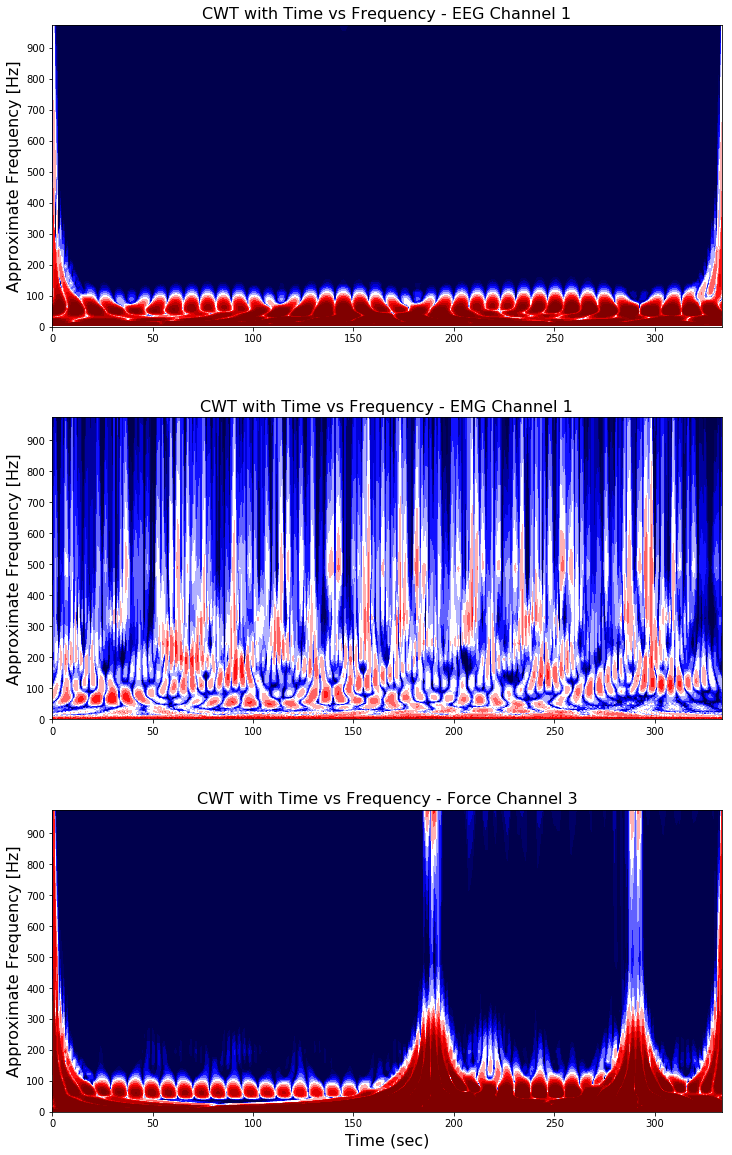

In [138]:
scales = np.arange(1,num_samples_per_trial+1)
wavelet_type = 'morl'
fig, axes = plt.subplots(3, figsize=(12,20))
fig.subplots_adjust(hspace=0.3)
for i, signal in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    coef_matrix, freqs = pywt.cwt(signal, scales, wavelet_type, sampling_period=dt)
    power = (abs(coef_matrix)) ** 2
    levels = [0.0078125, 0.015625 ,0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]
    contourlevels = np.log2(levels)
    im = axes[i].contourf(time, freqs, np.log2(power), contourlevels, 
                          extend='both',cmap=plt.cm.seismic)
    #axes[i].matshow(coef_matrix) 
    axes[i].set_ylabel('Approximate Frequency [Hz]', fontsize=16)
    axes[i].set_xlim(time.min(), time.max())
    if i == 0:
        axes[i].set_title('CWT with Time vs Frequency - EEG Channel 1', fontsize=16)
    elif i == 1:
        axes[i].set_title('CWT with Time vs Frequency - EMG Channel 1', fontsize=16)
    else:
        axes[i].set_title('CWT with Time vs Frequency - Force Channel 3', fontsize=16)
        axes[i].set_xlabel('Time (sec)', fontsize=16)
    yticks = np.arange(0, round(freqs.max()/100)*100, step=100)
    axes[i].set_yticks(yticks)

plt.show()

# Vector Auto-Regression Based on Discrete Wavelet Transform Coefficients